# Loss Functions
This document outlines a variety of different loss functions that we have discussed.

## Notation
We follow the notation in Schmidt et. al. as closely as possible

- $D(I_a, I_b, u_a, u_b)$ is the L2 norm between descriptor of image $I_a$ at pixel $u_a$ and the descriptor of image $I_b$ at pixel $u_b$. 
- $\Delta(u, u')$ is the L2 norm in pixel space between location $u$ and location $u'$.



## Background Non-Match Loss

Randomly sample lots of background pixels, call them $U_b$. Then the loss is

$$ loss = \sum_{u_b \in U_b} \min\left( M - D(I_a, u_a, I_b, u_b), 0  \right) $$

## Loss function to target "best match"

One task that we are particularly interested in is given a pixel $u_a$ in image $I_a$, find the corresponding pixel $u_b^* = g(I_b, u_a)$. The best-match pixel $u_b'$ in image $I_b$ can be found by computing

$$ u_b' = \arg \min_{u_b} D(I_a,u_a,I_b,u_b)$$

Consider the non-match loss given by

$$ l = \sum_{u_b \in I_b} \min(\Delta(u_b, u_b^*), M_p) \cdot \min\left( M_d - \frac{D(I_a, u_a, I_b, u_b)}{D(I_a, u_a, I_b, u_b^*)}, 0  \right) $$

Reasonable settings could be

$$ M_p = 100, M_b = 1.5$$

The idea is to penalize points that are within a fraction $M_b$ of l2 norm in descrptor space of the "true match" $u_b^*$. We also want to penalize more heavily points that are further away in pixel space.

We could also 

### Variations
There are multiple options for the second term in the above sum. A few options are listed below. It's unclear to me what the tradeoffs between these different fomulations are. Tanner et. al. uses a formulation like (2), while some of the other papers with triplet loss use something more similar to (1). 

1. $ \min\left( M - \frac{D(I_a, u_a, I_b, u_b)}{D(I_a, u_a, I_b, u_b^*)}, 0  \right)$
2. $\min\left( M - D(I_a, u_a, I_b, u_b), 0  \right)$
3. $\min\left( M \cdot D(I_a, u_a, I_b, u_b^*) - D(I_a, u_a, I_b, u_b), 0  \right)$


### Implementation Details

If we implement the above over the "entire" image $I_b$ then this would be prohibitively expensive since for each choice of $u_a$ we would have to do the norm-diff over the entire image. One option is to heavily down-sample the number the masked image. Let $\Gamma_b$ be the downsampled masked image. Then just sum over those pixels.`

## Match-loss

For matches we have simply:

$$ loss =D(I_a, u_a, I_b, u_b)^2 $$

This next mini section addresses whether or not we should square D or not.

### L2 squared or not L2 squared?

Consider three points, $A$, $B$, $C$ that should all be matches with each other.  Consider the L2 norms between them, call them $AB$, $BC$, and $CA$.

If L2 is not squared, the these two situations have the same cost:

$AB = BC = CA = 5 \rightarrow \sum(\cdot) = 15$

$AB = BC = 1, CA = 13 \rightarrow \sum(\cdot) = 15$

Whereas is L2 is squared, then the situation is much different:

$AB = BC = CA = 5 \rightarrow \sum(\cdot)^2 = 75$

$AB = BC = 1, CA = 13 \rightarrow \sum(\cdot)^2 = 171$

#### Plotting the match loss

It is dead simple but let's plot the match loss as a function of D:


In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1,.001)
y = x**2
plt.plot(x,y)
plt.title("Match loss")
plt.xlabel("D")
plt.ylabel("loss")
plt.show()

<Figure size 640x480 with 1 Axes>

## Two different types of non-match loss

Consider the loss function for non-matches verbatim from Schmidt et al 2017:

$$ loss = \max(0, M - D(I_a, u_a, I_b, u_b) )^2 $$

And consider the slight variation we have been using that performs approximately the same:

$$ loss = \max(0, M - D(I_a, u_a, I_b, u_b)^2 ) $$


#### First let's plot the Schmidt et al verbatim non-match-loss function

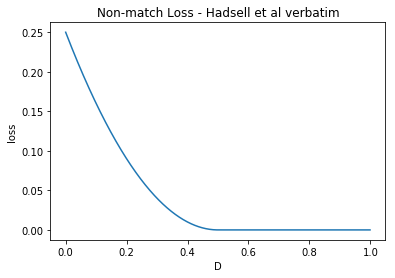

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1,.001)
M = 0.5
y = M - x
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y)
plt.title("Non-match Loss - Hadsell et al verbatim")
plt.xlabel("D")
plt.ylabel("loss")
plt.show()

#### Now let's plot the variation

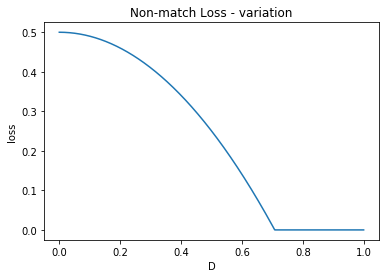

In [3]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1,.001)
M = 0.5
y = M - x**2
y = np.where(y>0,y,0)
plt.plot(x,y)
plt.title("Non-match Loss - variation")
plt.xlabel("D")
plt.ylabel("loss")
plt.show()

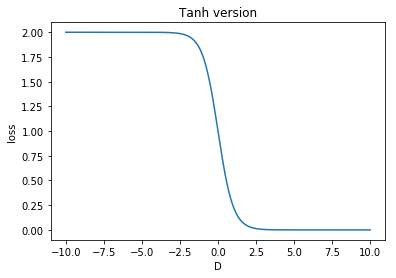

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch

x = torch.from_numpy(np.arange(-10,10,.001))
M = 0.5
y = -torch.tanh(x)+1
#y = .where(y>0,y,0)
x = x.numpy()
y = y.numpy()
plt.plot(x,y)
plt.title("Tanh version")
plt.xlabel("D")
plt.ylabel("loss")
plt.show()

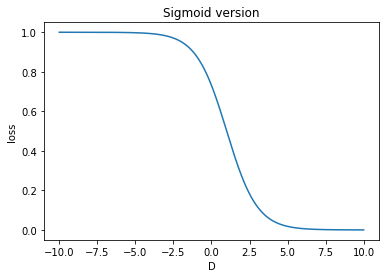

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

x = torch.from_numpy(np.arange(-10,10,.001))
M = 0.5
y = -torch.sigmoid(x-1)+1
#y = .where(y>0,y,0)
x = x.numpy()
y = y.numpy()
plt.plot(x,y)
plt.title("Sigmoid version")
plt.xlabel("D")
plt.ylabel("loss")
plt.show()

#### We could also consider not squared L2 norm for the backgroud non-matches:

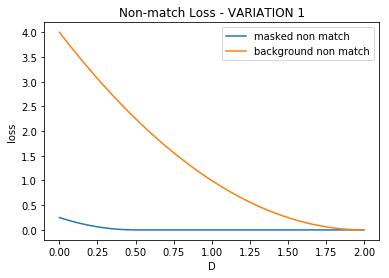

In [6]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,2,.001)
M_masked = 0.5
y = M_masked - x
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="masked non match")
x = np.arange(0,2,.001)
M_background = 2.0
y = (M_background - x)
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="background non match")
plt.title("Non-match Loss - VARIATION 1")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()

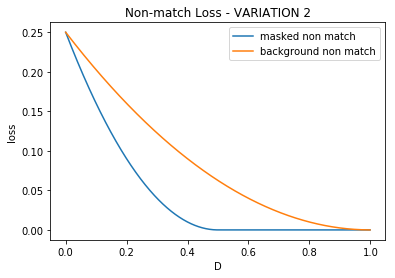

In [7]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,1,.001)
M_masked = 0.5
y = M_masked - x
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="masked non match")
x = np.arange(0,1,.001)
M_background = 1.0
y = (M_background - x)*(M_masked/M_background)
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="background non match")
plt.title("Non-match Loss - VARIATION 2")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()

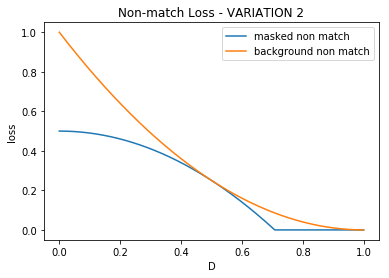

In [8]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,1,.001)
M_masked = 0.5
y = M_masked - x**2
y = np.where(y>0,y,0)
plt.plot(x,y,label="masked non match")
x = np.arange(0,1,.001)
M_background = 1.0
y = (M_background - x)
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="background non match")
plt.title("Non-match Loss - VARIATION 2")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()

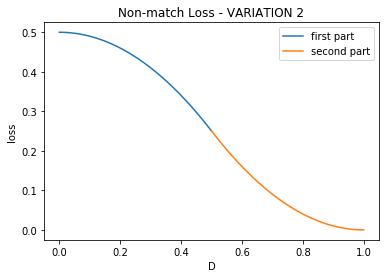

In [9]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,0.5,.001)
M_masked = 0.5
y = M_masked - x**2
y = np.where(y>0,y,0)
plt.plot(x,y,label="first part")
x = np.arange(0.5,1.0,.001)
M_background = 1.0
y = (M_background - x)
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="second part")
plt.title("Non-match Loss - VARIATION 2")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()

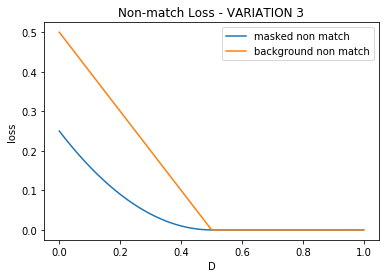

In [10]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,1,.001)
M_masked = 0.5
y = M_masked - x
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="masked non match")
x = np.arange(0,1,.001)
M_background = 0.5
y = (M_background - x)*(M_masked/M_background)
y = np.where(y>0,y,0)
y = y
plt.plot(x,y,label="background non match")
plt.title("Non-match Loss - VARIATION 3")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()

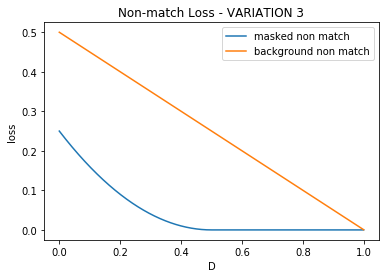

In [11]:
import matplotlib.pyplot as plt
import numpy as np


x = np.arange(0,1,.001)
M_masked = 0.5
y = M_masked - x
y = np.where(y>0,y,0)
y = y**2
plt.plot(x,y,label="masked non match")
x = np.arange(0,1,.001)
M_background = 1.0
y = (M_background - x)*(M_masked/M_background)
y = np.where(y>0,y,0)
y = y
plt.plot(x,y,label="background non match")
plt.title("Non-match Loss - VARIATION 3")
plt.xlabel("D")
plt.ylabel("loss")
plt.legend()
plt.show()